## Detect Sponsorship Theme in Video Descriptions

This notebook adds a new feature `sponsor_score` letting us know if a video description contains a sponsorship theme. 

When a video is sponsored, the description often contains a link to the sponsor's webside along with a short description of the product or service being promoted. Many of these descriptions are similar and contain the same keywords such as **sponsored**, **promotion** or **code**. To detect this, we perform the following:

1. For each video description, we tokenize the description, remove stop words and stem the remaining words.

2. From a list of keywords related to sponsorship, we create a list of stemmed keywords and count the number of words in the description that match the stemmed keywords. The keywords can be found in [sponsor_vocabulary.csv](../data/sponsor_vocabulary.csv).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import udf, mean, stddev
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow with repartitioning.
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

import nltk
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
USE_SUBDATASETS = False # Set to True to use the subdatasets, only for testing purposes.
PATH_METADATAS_SRC = '../data/subdata/yt_metadata_en_sub' if USE_SUBDATASETS else '../data/yt_metadata_en.jsonl'

### Define the Theme Detection Function

Firstly, we define the function giving a score to a video description based on the appearance of keywords related to sponsorship.

In [3]:
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])
    
metadatas = spark.read.json(PATH_METADATAS_SRC, schema=schema)

In [4]:
# Load the stemmed keywords related to sponsorships
PATH_SPONSOR_VOCABULARY_SRC = '../data/sponsor_vocabulary.csv'
sponsor_vocab = pd.read_csv(PATH_SPONSOR_VOCABULARY_SRC, header=None, encoding="utf-8").to_numpy().flatten()
sponsor_vocab = np.array([stemmer.stem(word) for word in sponsor_vocab])
sponsor_vocab

array(['sponsor', 'subscript', 'video', 'first', 'free', 'bonu', 'thank',
       'code', 'gift', 'discount', 'premium', 'coupon', 'deal', 'sale',
       'promo', 'pack', 'worldwid', 'ship', 'includ', 'limit', 'stock',
       'avail', 'trial', 'offer', 'money', 'annual', 'month', 'monthli',
       'week', 'weekli', 'day', 'daili', 'today', 'off', 'onli', 'now',
       'extra', 'here', 'save', 'order', 'tri', 'use', 'download',
       'purchas', 'shop', 'buy', 'get', 'unlimit', '$'], dtype='<U9')

In [5]:
def get_sponsor_score(description: str) -> int:
    """
    Returns the number of times a word from the sponsor vocabulary appears in the description.

    Args:
        description (str): The description of the video.
    
    Returns:
        int: The sponsor score, i.e. the number of times a word from the sponsor vocabulary appears in the description.
    """
    
    if description is None:
        return 0

    # Tokenize
    tokens = word_tokenize(description)
    # Remove stop words
    tokens = [word.lower() for word in tokens if word not in stop_words]
    # Stemming
    if stemmer is not None:
        tokens = [stemmer.stem(word) for word in tokens]
    score = sum(1 for word in tokens if word in sponsor_vocab)

    return score
    

Below are two examples of video descriptions. The first one is sponsored, having a score of $16$. This is greater than the score of the second video description, which is not sponsored.

In [6]:
str1 = "Try out my quantum mechanics course (and many others on math and science) on https://brilliant.org/sabine. You can get started for free, and the first 200 will get 20% off the annual premium subscription.\n\nToday we’ll talk about how to build a radio telescope – on the moon, recent wormhole headlines, the Artemis 1 launch and why it was delayed, quantum microscopes and the status of quantum computing, the first metaverse nation, manta rays, advances in material design, the link between chaos and biodiversity. And of course, the telephone will ring.\n\n👉 Transcript and references on Patreon ➜ https://www.patreon.com/Sabine\n💌 Sign up for my weekly science newsletter. It's free!  ➜ https://sabinehossenfelder.com/newsle...\n📖 My new book \"Existential Physics\" is now on sale ➜ http://existentialphysics.com/\n🔗 Join this channel to get access to perks ➜ https://www.youtube.com/channel/UC1yN...\n\n00:00 Intro\n00:35 Plans For a Radio-Telescope on the Moon\n02:31 Are Black Holes Wormholes?\n04:12 Why the Delays With the Artemis 1 Launch?\n06:00 Prototype of a Quantum Microscope\n07:25 Still No Useful Quantum Advantage\n08:34 Big Population of Manta Rays Found\n10:00 The First Metaverse Nation\n11:36 Progress in Material Science\n12:41 Chaos in the Evolution of a Single Species\n13:25 Check Out My Quantum Mechanics Course\n\n#science #sciencenews"
print(str1)

Try out my quantum mechanics course (and many others on math and science) on https://brilliant.org/sabine. You can get started for free, and the first 200 will get 20% off the annual premium subscription.

Today we’ll talk about how to build a radio telescope – on the moon, recent wormhole headlines, the Artemis 1 launch and why it was delayed, quantum microscopes and the status of quantum computing, the first metaverse nation, manta rays, advances in material design, the link between chaos and biodiversity. And of course, the telephone will ring.

👉 Transcript and references on Patreon ➜ https://www.patreon.com/Sabine
💌 Sign up for my weekly science newsletter. It's free!  ➜ https://sabinehossenfelder.com/newsle...
📖 My new book "Existential Physics" is now on sale ➜ http://existentialphysics.com/
🔗 Join this channel to get access to perks ➜ https://www.youtube.com/channel/UC1yN...

00:00 Intro
00:35 Plans For a Radio-Telescope on the Moon
02:31 Are Black Holes Wormholes?
04:12 Why th

In [7]:
score1 = get_sponsor_score(str1)
print(f"The sponsorhip score is {score1}.")

The sponsorhip score is 16.


In [8]:
str2 = "All rise for the most iconic housewife, heiress of Hilton Hotels & mother of queen Paris Hilton 👑💖\n\n☆ MY MERCH SHOP: \n☆ https://teespring.com/stores/offensiv... \n\nMY INSTAGRAM: @offensivetea.yt \nhttps://www.instagram.com/offensivete... \n\nBACK-UP ACCOUNT:\nhttps://www.youtube.com/channel/UCgds... \n\nPATREON:\nhttps://www.patreon.com/offensivetea \n\nLooking for missing copyrighted videos? They're probably on my Vimeo page!\nhttps://vimeo.com/offensivetea\n\n\nBUSINESS ONLY:\noffensivetea@hotmail.com\n\n\n\n#RHOBH #kathyhilton #housewives #iconic #offensivetea #meme #parishilton #funnymoments #stantwitter #edit"
print(str2)

All rise for the most iconic housewife, heiress of Hilton Hotels & mother of queen Paris Hilton 👑💖

☆ MY MERCH SHOP: 
☆ https://teespring.com/stores/offensiv... 

MY INSTAGRAM: @offensivetea.yt 
https://www.instagram.com/offensivete... 

BACK-UP ACCOUNT:
https://www.youtube.com/channel/UCgds... 

PATREON:
https://www.patreon.com/offensivetea 

Looking for missing copyrighted videos? They're probably on my Vimeo page!
https://vimeo.com/offensivetea


BUSINESS ONLY:
offensivetea@hotmail.com



#RHOBH #kathyhilton #housewives #iconic #offensivetea #meme #parishilton #funnymoments #stantwitter #edit


In [9]:
score2 = get_sponsor_score(str2)
print(f"The sponsorhip score is {score2}.")

The sponsorhip score is 3.


### Apply the Theme Detection Function on the Dataset

We apply the function on the dataset and save the results in a new column `sponsor_score`.

In [10]:
get_sponsor_score_udf = udf(get_sponsor_score, IntegerType())
metadatas_sponsor_scores = metadatas \
    .withColumn('sponsor_score', get_sponsor_score_udf(metadatas.description)) \
    .cache() \
    .select('display_id', 'sponsor_score')

In [12]:
metadatas_sponsor_scores.show()

+-----------+-------------+
| display_id|sponsor_score|
+-----------+-------------+
|SBqSc91Hn9g|            2|
|UuugEl86ESY|            1|
|oB4c-yvnbjs|            2|
|ZaV-gTCMV8E|            2|
|cGvL7AvMfM0|            3|
|iVADSRjaLtQ|            2|
|ypVcK9mldPc|            1|
|qA1NayP9cNY|            2|
|CWdSl9ta4Rg|            1|
|64dCTkxCHpY|            2|
|rU2iDhVd-bI|            2|
|y5IvyZlzELs|            1|
|riSUG1R4Ckw|            1|
|C_dN36VjbZA|            2|
|E_cfDMDd0YM|            1|
|zuwQeKIhp2o|            2|
|dzcd5pen7Cw|            2|
|qYLAxjuoDtI|            2|
|L_n9FljLN-c|            1|
|srfrVHb8KGw|            2|
+-----------+-------------+
only showing top 20 rows



### Analyse the Sponsorship Scores

We can now analyse the distribution of sponsorship scores.

In [25]:
# Collect all scores
scores = metadatas_sponsor_scores.select('sponsor_score')
scores = scores.rdd.flatMap(lambda x: x).collect()

In [28]:
max_score = max(scores)
print(f"The max score is {max_score}.")
min_score = min(scores)
print(f"The min score is {min_score}.")
mean_score = np.mean(scores)
print(f"The mean score is {mean_score:.2f}.")
median_score = np.median(scores)
print(f"The median score is {median_score:.2f}.")

The max score is 1028.
The min score is 0.
The mean score is 2.7430393426959836.
The median score is 1.0.


The maximum score is $1028$, which clearly seems to be an outlier. The mean score is $2.74$ and the median score is $1$. The distribution might be **right-skewed** as the mean is greater than the median. Let us look ad the distribution in more detail.

In [38]:
shifted_scores = [score + 1 for score in scores]

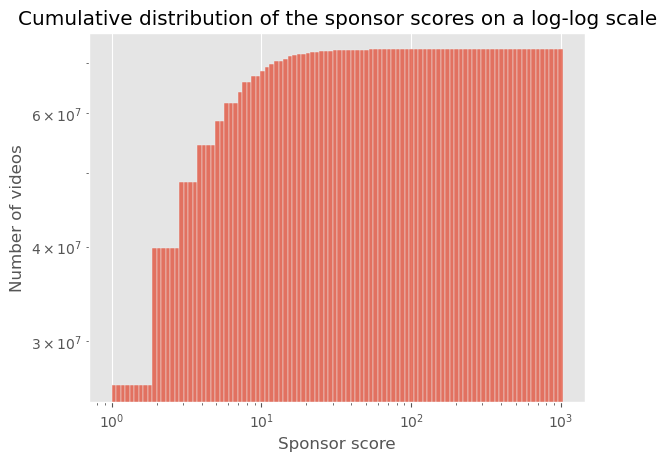

In [41]:
sns.histplot(shifted_scores, bins=100, log_scale=(True, True), cumulative=True)
plt.title("Cumulative distribution of the sponsor scores on a log-log scale")
plt.xlabel("Sponsor score")
plt.ylabel("Number of videos")
plt.show()

Note that the distribution is shifted by $1$ to have a satisfying range for the log-log plot. The great majority of videos have a sponsor score between $0$ and $10$, which seems to be a reasonable range. Many videos have a score of $0$ or $1$, which means that they might not be sponsored. A higher score might indicate that the video is sponsored, but too high of a score might be considered as an outlier.

Finally, we write the results to a parquet file.

In [13]:
PATH_METADATAS_SPONSOR_SCORES_DST = '../data/generated/yt_metadata_en_sponsor_scores.parquet'

In [14]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_SPONSOR_SCORES_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_SPONSOR_SCORES_DST -Recurse -Force" # Windows

In [15]:
metadatas_sponsor_scores.write.parquet(PATH_METADATAS_SPONSOR_SCORES_DST, mode='overwrite')